In [35]:
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from google.colab import files
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve

In [17]:
zip_path = "/content/dataset.zip"  # Change this to the actual filename

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")  # Extract to a directory


In [18]:
# Define dataset paths
dataset_path = "/content/dataset"
positive_dir = os.path.join(dataset_path, "Positive")  # Crack images
negative_dir = os.path.join(dataset_path, "Negative")  # No-crack images

# Get all image paths
crack_images = glob(os.path.join(positive_dir, "*.jpg"))
no_crack_images = glob(os.path.join(negative_dir, "*.jpg"))

# Print dataset info
print(f"Total Crack Images: {len(crack_images)}")
print(f"Total No-Crack Images: {len(no_crack_images)}")


Total Crack Images: 20000
Total No-Crack Images: 20000


<ipython-input-19-7a83c103eb35>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="coolwarm")


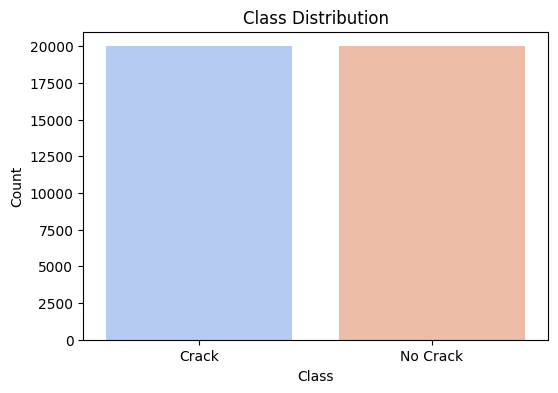

In [19]:
labels = ['Crack'] * len(crack_images) + ['No Crack'] * len(no_crack_images)

plt.figure(figsize=(6, 4))
sns.countplot(x=labels, palette="coolwarm")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**Checking Image Sizes**

Average Image Width: 227.00, Height: 227.00


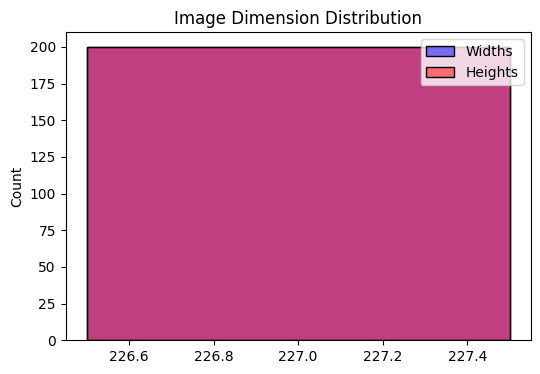

In [20]:
image_sizes = []
for img_path in crack_images[:100] + no_crack_images[:100]:  # Checking 100 images per class
    img = Image.open(img_path)
    image_sizes.append(img.size)

widths, heights = zip(*image_sizes)
print(f"Average Image Width: {np.mean(widths):.2f}, Height: {np.mean(heights):.2f}")

plt.figure(figsize=(6, 4))
sns.histplot(widths, kde=True, color="blue", label="Widths")
sns.histplot(heights, kde=True, color="red", label="Heights")
plt.legend()
plt.title("Image Dimension Distribution")
plt.show()


**Compute Image Stats(Mean & Std)**

In [21]:
def calculate_stats(image_list):
    means, stds = [], []

    for img_path in image_list[:500]:  # Checking first 500 images
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize
        means.append(np.mean(img))
        stds.append(np.std(img))

    return np.mean(means), np.mean(stds)

crack_mean, crack_std = calculate_stats(crack_images)
no_crack_mean, no_crack_std = calculate_stats(no_crack_images)

print(f"Crack Images - Mean: {crack_mean:.3f}, Std: {crack_std:.3f}")
print(f"No Crack Images - Mean: {no_crack_mean:.3f}, Std: {no_crack_std:.3f}")


Crack Images - Mean: 0.647, Std: 0.121
No Crack Images - Mean: 0.709, Std: 0.035


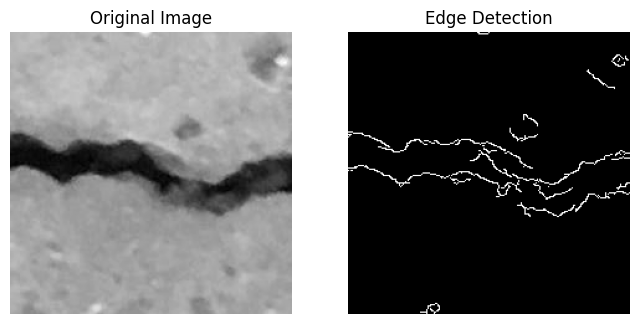

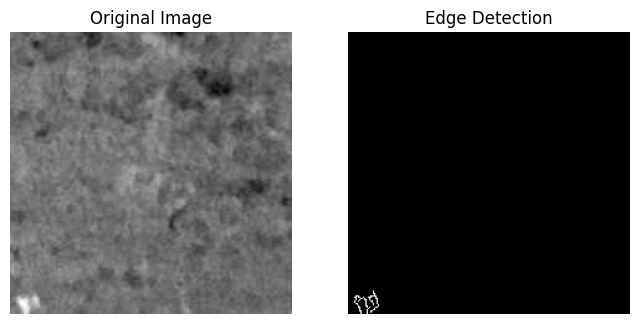

In [22]:
def show_edges(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, threshold1=50, threshold2=150)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Edge Detection")
    plt.axis("off")

    plt.show()

# Test edge detection
show_edges(crack_images[0])
show_edges(no_crack_images[0])


📌 Preprocessing Steps

1️⃣ Load images & resize (Ensure all images have the same shape)

2️⃣ Convert to grayscale (optional)

3️⃣ Normalize pixel values (Scale values between 0-1 or -1 to 1)

4️⃣ Data Augmentation (Flip, rotate, zoom, etc.)

5️⃣ Prepare for model training (Create train-test splits & format data)



In [23]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def grayscale_conversion(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    gray_image = np.expand_dims(gray_image, axis=-1)  # Add a third dimension
    return np.repeat(gray_image, 3, axis=-1)  # Duplicate the single channel into 3 channels

def noise_removal(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

# Update the ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: noise_removal(grayscale_conversion(x)),  # Combine grayscale and noise removal
    validation_split=0.2
)

# Load training data
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'  # Load training set
)

# Load validation data
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'  # Load validation set
)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [24]:
# Define data augmentation pipeline
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: noise_removal(grayscale_conversion(x)),  # Combine grayscale and noise removal
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Apply augmentation to training set
train_augmented = augment_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

Found 32000 images belonging to 2 classes.


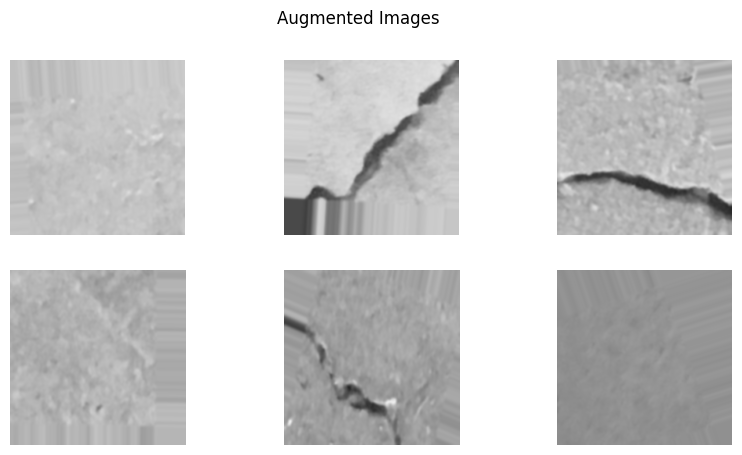

In [25]:
# Get a batch of images
augmented_images, _ = next(train_augmented)

# Plot some images
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    # Display grayscale images using cmap='gray'
    plt.imshow(augmented_images[i].squeeze(), cmap='gray')
    plt.axis("off")
plt.suptitle("Augmented Images")
plt.show()

In [26]:
# Function to extract HOG features (more compact than raw pixels)
def extract_features(image_path, img_size=(64, 64)):
    # Load and resize image (smaller size for faster processing)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)

    # Extract HOG features
    win_size = img_size
    cell_size = (8, 8)
    block_size = (16, 16)
    block_stride = (8, 8)
    num_bins = 9

    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)
    features = hog.compute(img)

    return features.flatten()

In [27]:
# Collect features and labels (with a progress bar)
def prepare_dataset(crack_images, no_crack_images, sample_size=2000):
    # Limit dataset size if needed
    crack_sample = crack_images[:sample_size] if len(crack_images) > sample_size else crack_images
    no_crack_sample = no_crack_images[:sample_size] if len(no_crack_images) > sample_size else no_crack_images

    print("Extracting features...")
    X = []
    y = []

    # Process crack images
    for img_path in tqdm(crack_sample):
        features = extract_features(img_path)
        X.append(features)
        y.append(1)  # 1 for crack

    # Process no-crack images
    for img_path in tqdm(no_crack_sample):
        features = extract_features(img_path)
        X.append(features)
        y.append(0)  # 0 for no crack

    return np.array(X), np.array(y)

# Prepare dataset with sampling (adjust sample_size as needed)
X, y = prepare_dataset(crack_images, no_crack_images, sample_size=2000)

Extracting features...


100%|██████████| 2000/2000 [00:00<00:00, 3357.31it/s]


In [28]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for better KNN performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# PCA to further reduce dimensionality (optional but recommended)
pca = PCA(n_components=100)  # Adjust number of components as needed
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Reduced feature dimension from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}")



Reduced feature dimension from 1764 to 100


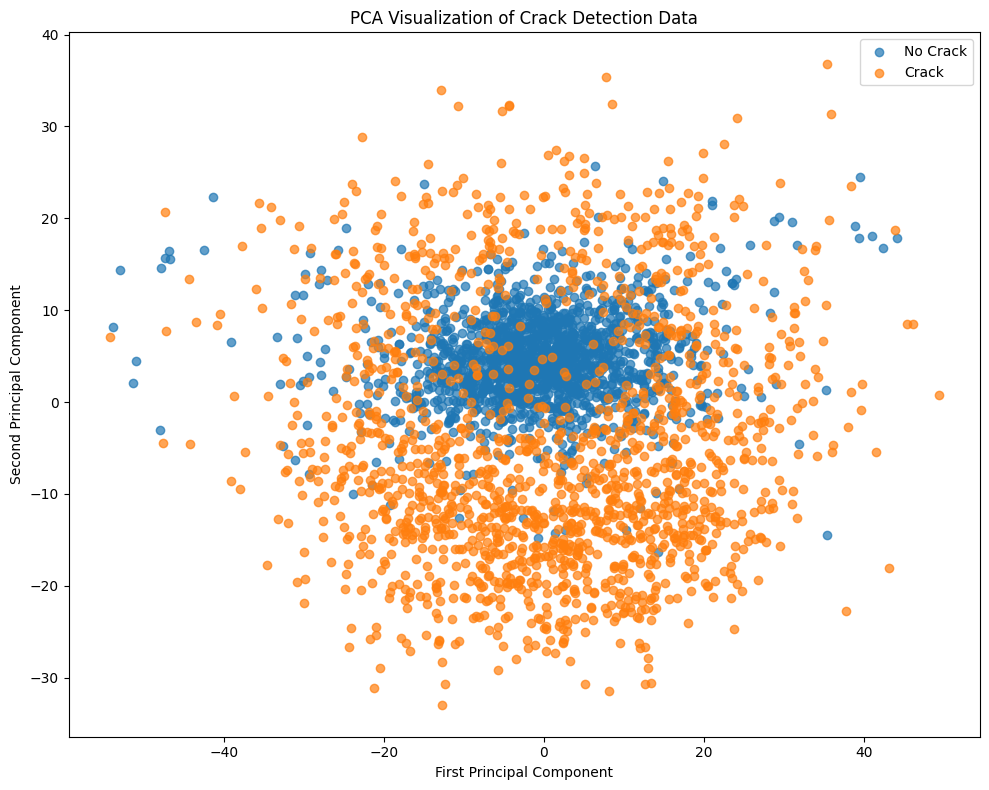

In [30]:
# Visualize data in 2D PCA space (using the first two components)
plt.figure(figsize=(10, 8))
for i, target_name in enumerate(['No Crack', 'Crack']):
    plt.scatter(X_train_pca[y_train == i, 0], X_train_pca[y_train == i, 1],
                alpha=0.7, label=target_name)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.title('PCA Visualization of Crack Detection Data')
plt.tight_layout()
plt.show()

In [31]:
# Implementing SVC Model
svc = SVC(random_state=42)
svc.fit(X_train_pca, y_train)

SVC(random_state=42)

In [32]:
# Evaluating SVC
y_pred_basic = svc.predict(X_test_pca)
print("\nBasic SVC on PCA Results:")
print(f"Accuracy: {svc.score(X_test_pca, y_test):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_basic))


Basic SVC on PCA Results:
Accuracy: 0.9875

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       378
           1       1.00      0.98      0.99       422

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



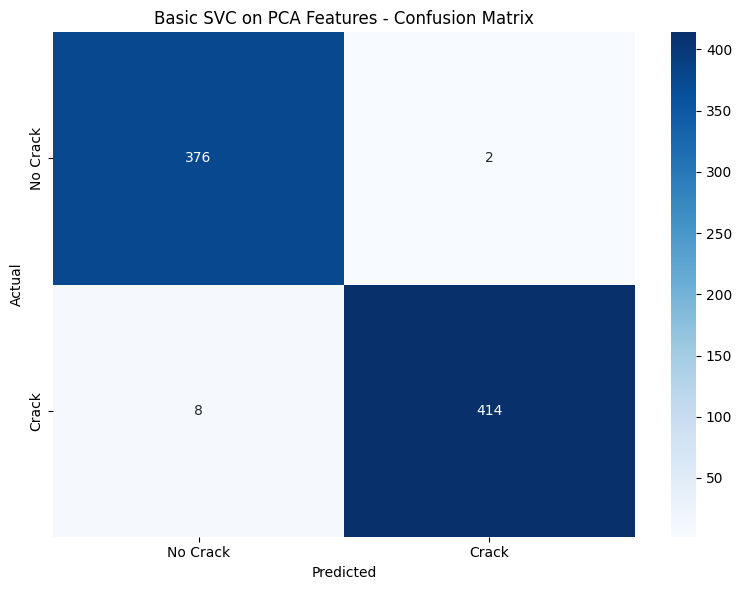

In [33]:
# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_basic)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Crack', 'Crack'],
            yticklabels=['No Crack', 'Crack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Basic SVC on PCA Features - Confusion Matrix')
plt.tight_layout()
plt.show()

In [36]:
# Checking if SVC model overfits or not
train_accuracy = svc.score(X_train_pca, y_train)
test_accuracy = svc.score(X_test_pca, y_test)

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Accuracy difference: {train_accuracy - test_accuracy:.4f}")

# Perform cross-validation to see consistency
print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(svc, X_train_pca, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"CV standard deviation: {cv_scores.std():.4f}")

# Check learning curve to detect overfitting
train_sizes, train_scores, test_scores = learning_curve(
    svc, X_train_pca, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy', n_jobs=-1
)

# Calculate mean and std for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

Training accuracy: 0.9972
Test accuracy: 0.9875
Accuracy difference: 0.0097

Performing 5-fold cross-validation...
Cross-validation scores: [0.9859375 0.975     0.9875    0.9890625 0.9890625]
Mean CV accuracy: 0.9853
CV standard deviation: 0.0053

Generating learning curve...


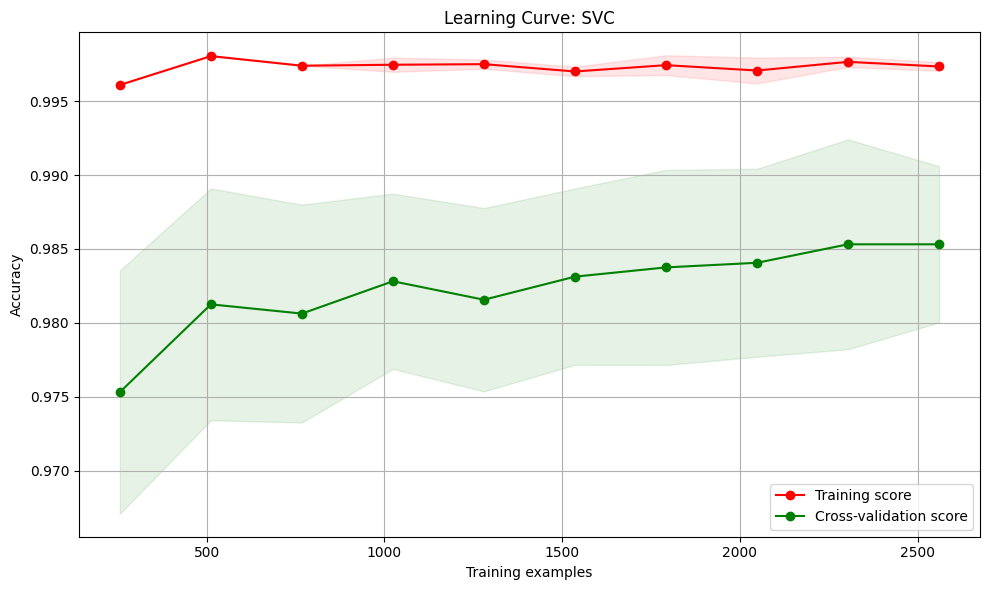

In [37]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve: SVC")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.grid()

plt.fill_between(train_sizes, train_mean - train_std,
                train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std,
                test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Slight overfitting: There is a small but consistent gap between training and validation accuracy. This suggests some overfitting, but it's not severe (a severe case would show a much larger gap).
Good generalization: The cross-validation score is very high (98.5%) and improves with more data, indicating the model generalizes well.

In [ ]:
# Train KNN with optimized parameters
print("Training KNN model...")
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='kd_tree',
                          leaf_size=30, n_jobs=-1)  # n_jobs=-1 uses all CPU cores
knn.fit(X_train_pca, y_train)

Accuracy: 0.8950

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       378
           1       1.00      0.80      0.89       422

    accuracy                           0.90       800
   macro avg       0.91      0.90      0.89       800
weighted avg       0.91      0.90      0.89       800



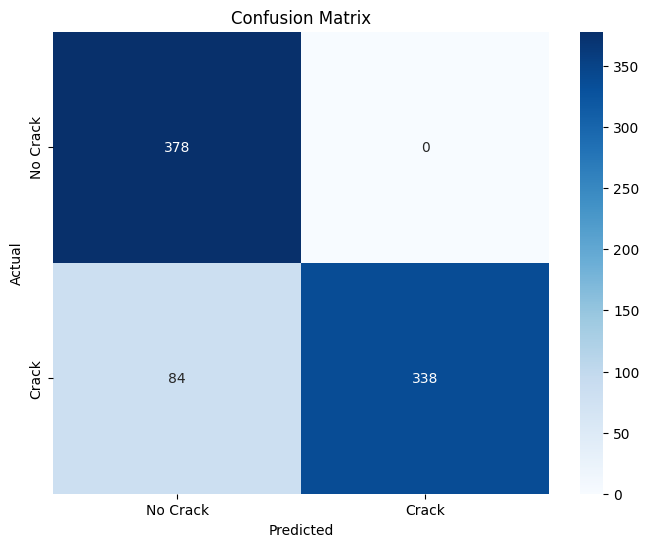

In [ ]:
# Evaluate model
y_pred = knn.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Crack', 'Crack'],
            yticklabels=['No Crack', 'Crack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Testing k=1
Testing k=3
Testing k=5
Testing k=7
Testing k=9
Testing k=11
Testing k=13
Testing k=15
Testing k=17
Testing k=19


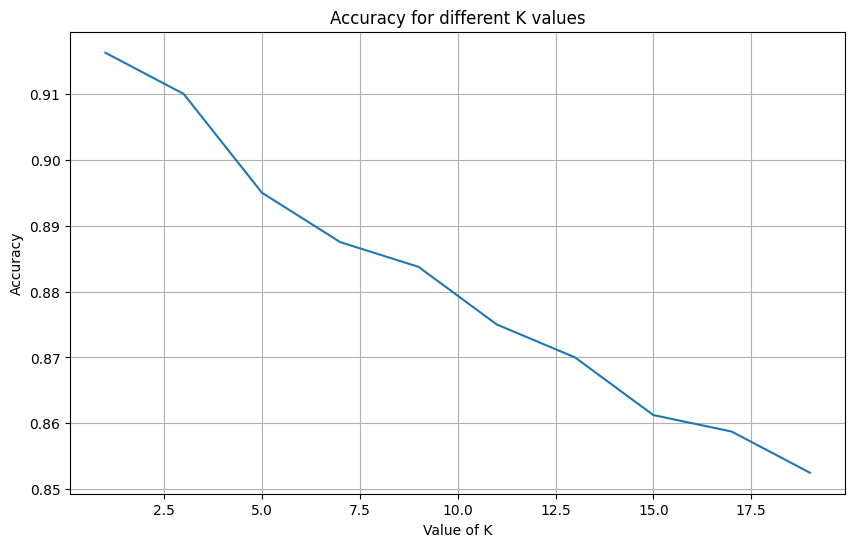

Best K value: 1


In [ ]:
# Find optimal K value
def find_optimal_k(X_train, y_train, X_test, y_test, k_range=range(1, 20, 2)):
    k_scores = []
    for k in k_range:
        print(f"Testing k={k}")
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
        knn.fit(X_train, y_train)
        score = knn.score(X_test, y_test)
        k_scores.append(score)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for different K values')
    plt.grid(True)
    plt.show()

    # Return best k
    best_k = k_range[np.argmax(k_scores)]
    return best_k

best_k = find_optimal_k(X_train_pca, y_train, X_test_pca, y_test)
print(f"Best K value: {best_k}")